In [1]:
import numpy as np
from numpy.random import rand
from numpy.linalg import solve
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from ldmm import LDMM
from ldmm import ldmm_iteration

random_state=1

## Initialization

In [2]:
t = np.arange(-np.pi, np.pi, 0.01)
n = t.shape[0]
print(n)

X_true = np.concatenate((np.cos(t).reshape(-1, 1), np.sin(t).reshape(-1, 1)), axis=1)

# Embedding into D-dimensional space
D = 10
X_true = np.concatenate((X_true, np.zeros((n, D-X_true.shape[1]))), axis=1)

magnitude = 0.8
noise = magnitude * (rand(n, D) - 0.5)
X = X_true + noise

629


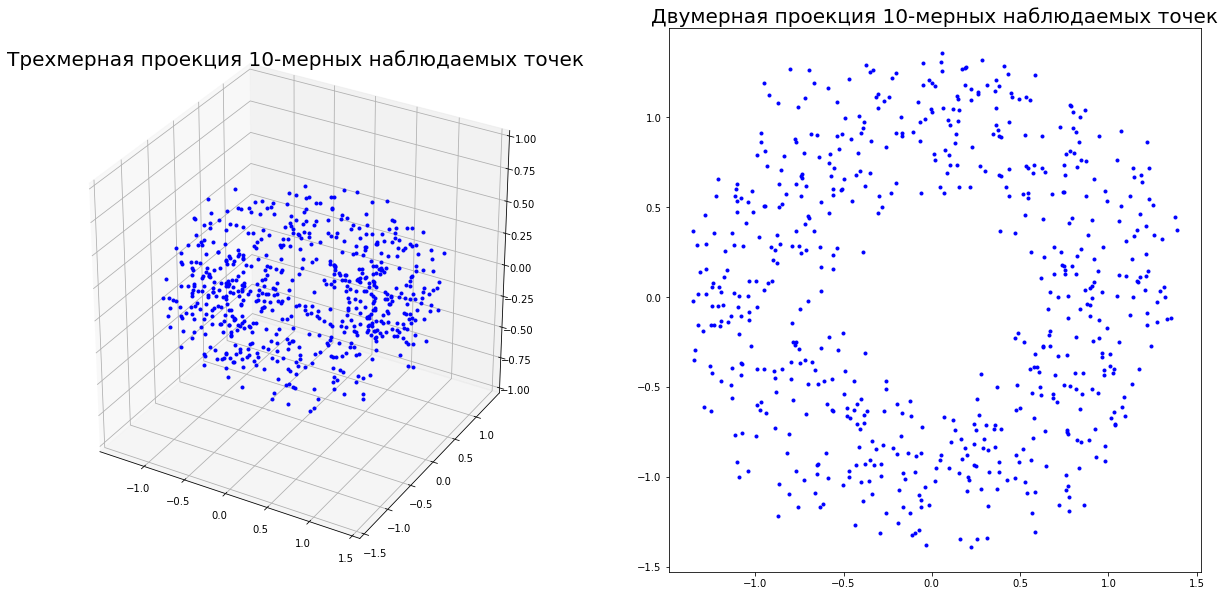

In [3]:
fig = plt.figure(figsize=(21, 10))
ax = fig.add_subplot(121, projection='3d')
ax.plot(X[:, 0], X[:, 1], X[:, 2],'b.',)
ax.set_zlim3d(-1,1)
#ax.set_title('3D projection of ' + str(D) + '-dimensional point cloud', fontsize=16)
ax.set_title('Трехмерная проекция ' + str(D) + '-мерных наблюдаемых точек', fontsize=20)
ax = fig.add_subplot(122)
ax.plot(X[:, 0], X[:, 1],'b.',)
#ax.set_title('2D projection of ' + str(D) + '-dimensional point cloud', fontsize=16)
ax.set_title('Двумерная проекция ' + str(D) + '-мерных наблюдаемых точек', fontsize=20)
#plt.savefig('sample.png')
plt.show()
plt.close()

In [4]:
h = 0.1
X_recovered = LDMM(X, lambd=0.5, mu=0.2 * n * h, h=h, n_iterations=8)
print(np.linalg.norm(X_recovered - X_true))

6.2240633641


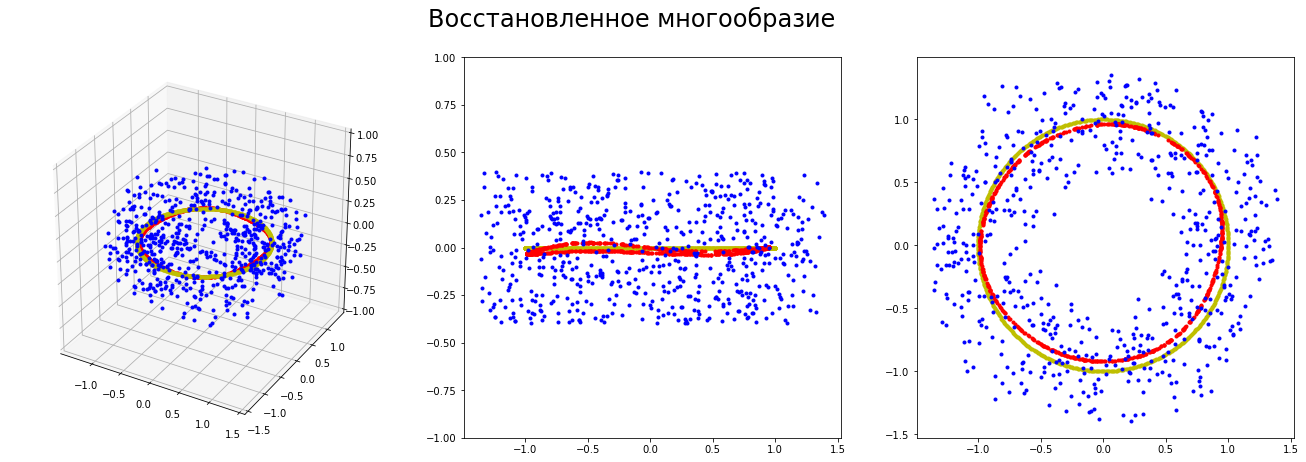

In [5]:
fig = plt.figure(figsize=(23, 7))
ax = fig.add_subplot(131, projection='3d')
ax.plot(X_recovered[:, 0], X_recovered[:, 1], X_recovered[:, 2],'r.',)
ax.plot(X_true[:, 0], X_true[:, 1], X_true[:, 2],'y.',)
ax.plot(X[:, 0], X[:, 1], X[:, 2],'b.',)
ax.set_zlim3d(-1,1)
#ax.set_title('3D projection of the recovered manifold', fontsize=16)
ax = fig.add_subplot(132)
ax.plot(X_true[:, 0], X_true[:, 2],'y.',)
ax.plot(X_recovered[:, 0], X_recovered[:, 2],'r.',)
ax.plot(X[:, 0], X[:, 2],'b.',)
ax.set_ylim(-1,1)
#ax.set_title('2D projection of the recovered manifold', fontsize=16)
ax = fig.add_subplot(133)
ax.plot(X_true[:, 0], X_true[:, 1],'y.',)
ax.plot(X_recovered[:, 0], X_recovered[:, 1],'r.',)
ax.plot(X[:, 0], X[:, 1],'b.',)
#ax.set_title('2D projection of the recovered manifold', fontsize=16)
plt.suptitle('Восстановленное многообразие', fontsize=24)
#plt.savefig('ldmm_result.png')
plt.show()
plt.close()